### 0. Imports and requirements

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import os
import torch
from tqdm import trange


from sklearn.model_selection import train_test_split
import tqdm 


pd.set_option("display.max_columns", None)
sys.path.append('/kaggle/input/credit') # замени на свою
sys.path.append('../')



In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

### 1. Data Preprocessing

In [3]:
import dataset_preprocessing_utils
print(dir(dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


In [4]:
# тут тоже поставь свое 
TRAIN_DATA_PATH = "/kaggle/input/credit/data/train_data/" 
TEST_DATA_PATH = "/kaggle/input/credit/data/test_data/"

TRAIN_TARGET_PATH = "/kaggle/input/credit/data/train_target.csv"

In [5]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)

In [6]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

In [23]:
%%time
from collections import defaultdict


train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq
/kaggle/input/credit/data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_8.pq
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/test_data/test_data_0.pq
/kaggle/input/credit/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 46.8 s, sys: 34.4 s, total: 1min 21s
Wall time: 47.5 s


* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [7]:
import dataset_preprocessing_utils
print(dir(dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [8]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [10]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [11]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [12]:
TRAIN_BUCKETS_PATH = "data/train_buckets_rnn"
VAL_BUCKETS_PATH = "data/val_buckets_rnn"
TEST_BUCKETS_PATH = "data/test_buckets_rnn"

In [16]:
import shutil

for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    if os.path.exists(buckets_path):
        print(f"Удаляю папку {buckets_path}")
        shutil.rmtree(buckets_path)  # Удаляем директорию и её содержимое
    print(f"Создаю папку {buckets_path}")
    os.makedirs(buckets_path)  # Создаём директорию

Создаю папку data/train_buckets_rnn
Создаю папку data/val_buckets_rnn
Создаю папку data/test_buckets_rnn


In [17]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TRAIN_BUCKETS_PATH,
                            frame_with_ids=train,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_train

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_3.pq
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq
/kaggle/input/credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 9min 24s, sys: 1min 13s, total: 10min 38s
Wall time: 10min 16s


['data/train_buckets_rnn/processed_chunk_000.pkl',
 'data/train_buckets_rnn/processed_chunk_001.pkl',
 'data/train_buckets_rnn/processed_chunk_002.pkl',
 'data/train_buckets_rnn/processed_chunk_003.pkl']

In [18]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=VAL_BUCKETS_PATH,
                            frame_with_ids=val,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_val

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_3.pq
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq
/kaggle/input/credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 8min 58s, sys: 46.1 s, total: 9min 44s
Wall time: 9min 11s


['data/val_buckets_rnn/processed_chunk_000.pkl',
 'data/val_buckets_rnn/processed_chunk_001.pkl',
 'data/val_buckets_rnn/processed_chunk_002.pkl',
 'data/val_buckets_rnn/processed_chunk_003.pkl']

### 2. Modeling

In [19]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print('Using device:', device)

Using device: cuda


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворком, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [20]:
from data_generators import batches_generator
from pytorch_training import train_epoch, eval_model, inference
from training_aux import EarlyStopping

* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [21]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [24]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [46]:
class RNN_GRU(nn.Module):
    def __init__(self,
                 features,
                 embedding_projections,
                 rnn_units=128,
                 top_classifier_units=32,
                 bidirectional=False,
                 num_layers=1,
                 spatial_dropout = 0.0
                ):
        super(RNN_GRU, self).__init__()
       
        self._credits_cat_embeddings = nn.ModuleList([
            self._create_embedding_projection(*embedding_projections[feature])
            for feature in features
        ])
        
        input_size = sum([embedding_projections[x][1] for x in features])
        self._spatial_dropout = nn.Dropout1d(spatial_dropout)
        self._gru = nn.GRU(input_size=input_size,
                            hidden_size=rnn_units,
                            batch_first=True,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            )
        
        self._hidden_size = rnn_units * (2 if bidirectional else 1)

        self._maxpool = nn.AdaptiveMaxPool1d(1)
        self._avgpool = nn.AdaptiveAvgPool1d(1)
        self._top_classifier = nn.Sequential(nn.Linear(in_features=self._hidden_size * 2, 
                                                       out_features=top_classifier_units),
                                             nn.ReLU(),
                                             nn.Linear(in_features=top_classifier_units, out_features=1)
                                            )
        
        
    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)  # [B, T, input_size]
        embeddings_permute = concated_embeddings.permute(0, 2, 1)
        embeddings_dropped = self._spatial_dropout(embeddings_permute)
        embeddings = embeddings_dropped.permute(0, 2, 1)  # [B, T, input_size]
        
        
        gru_out, _ = self._gru(embeddings)  # [B, T, hidden_size]
        
        gp_input = gru_out.permute(0, 2, 1) # [B, input_size, T]
        max_pooled = self._maxpool(gp_input).squeeze(-1)  # [B, hidden_size]
        avg_pooled = self._avgpool(gp_input).squeeze(-1)  # [B, hidden_size]

        hidden = torch.cat([max_pooled, avg_pooled], dim=1)  # [B, hidden_size * 2]
        
        logit = self._top_classifier(hidden)
        return logit
        
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality + add_missing, embedding_dim=embed_size, padding_idx=padding_idx)


### 3. Training

In [47]:
shutil.rmtree('./checkpoints/', ignore_errors=True)
os.makedirs('./checkpoints/', exist_ok=True)

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [59]:

def train_model(model,
                optimizer,
                dataset_train,
                dataset_val,
                num_epochs, 
                train_batch_size,
                val_batch_size,
                path_to_checkpoints,
                es,
                device,
                scheduler=None):
    """
    Обучает модель, отслеживая значения ROC AUC для тренировки и валидации.

    Возвращает:
      best_model_path (str): путь к лучшей модели по валидационному ROC AUC.
      best_roc_auc (float): наилучшее значение ROC AUC на валидационной выборке.
      train_roc_auc_list (list): список ROC AUC на тренировке по эпохам.
      val_roc_auc_list (list): список ROC AUC на валидации по эпохам.
    """
    best_roc_auc = -float("inf")
    best_model_path = None
    train_roc_auc_list = []
    val_roc_auc_list = []
    
    for epoch in trange(num_epochs, desc="Training Epochs", unit="epoch", leave=True):
        # Обучаем модель на тренировочном датасете
        train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                    shuffle=True, print_loss_every_n_batches=500, device=device)
        
        # Оцениваем модель на валидационном датасете
        current_val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
        val_roc_auc_list.append(current_val_roc_auc)
        
        # Оцениваем модель на тренировочном датасете (для контроля переобучения)
        current_train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
        train_roc_auc_list.append(current_train_roc_auc)
        
        print(f"Epoch {epoch+1} completed. Train ROC AUC: {current_train_roc_auc}, Val ROC AUC: {current_val_roc_auc}")
       
        es(current_val_roc_auc, model)
        if es.early_stop:
            print("Early stopping reached. Stop training...")
            break
        if scheduler:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f"End of epoch, current lr = {current_lr:.2e}")
        # Сохраняем чекпоинт текущей эпохи (для истории)
        checkpoint_path = os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{current_val_roc_auc:.3f}.pt")
        torch.save(model.state_dict(), checkpoint_path)
    best_roc_auc = max(val_roc_auc_list)
    print(f"Training finished. Best model saved at: {best_model_path} with Val ROC AUC: {best_roc_auc}")
    return best_model_path, best_roc_auc, train_roc_auc_list, val_roc_auc_list


In [67]:
experiment_configs = [
{
        "name": "exp_GRU_adam_lr_000001_schCyclicLR_rnn_units128_tpu32_bd1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 1e-5,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "spatial_dropout":0.05
            },
        "schedule":True,
        "early_stopping_patience": 3
    }
]

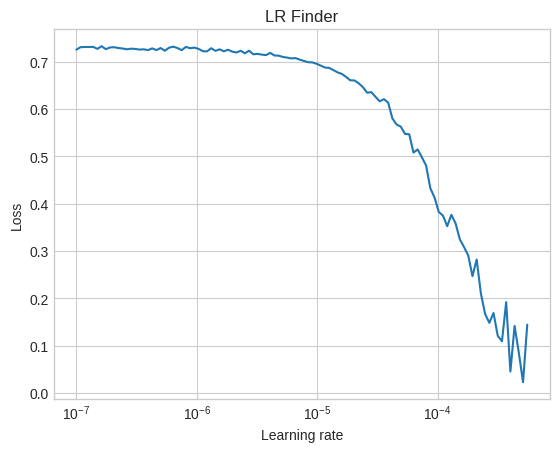

In [69]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from data_generators import batches_generator

def find_lr(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    dataset: list,
    device: torch.device,
    batch_size: int = 64,
    start_lr: float = 1e-7,
    end_lr: float = 10,
    num_it: int = 100
):
    """
    Пробегаем num_it батчей, экспоненциально увеличивая lr от start_lr до end_lr,
    собираем loss и рисуем его в логарифмической шкале.
    """
    model.train()
    lr_mult = (end_lr / start_lr) ** (1 / num_it)
    lr = start_lr
    for pg in optimizer.param_groups:
        pg['lr'] = lr

    lrs = []
    losses = []
    best_loss = float('inf')

    gen = batches_generator(dataset, batch_size=batch_size, shuffle=True,
                             device=device, is_train=True, output_format="torch")
    it = iter(gen)
    for iteration in range(num_it):
        try:
            batch = next(it)
        except StopIteration:
            it = iter(batches_generator(dataset, batch_size, True, device, True, "torch"))
            batch = next(it)

        optimizer.zero_grad()
        preds = model(batch["features"])
        loss = loss_fn(preds.flatten(), batch["label"].float())
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        # запоминаем и проверяем взрыв
        lrs.append(lr)
        losses.append(loss.item())
        if loss.item() > best_loss * 4:
            break
        if loss.item() < best_loss:
            best_loss = loss.item()

        # обновляем lr
        lr *= lr_mult
        for pg in optimizer.param_groups:
            pg['lr'] = lr

    # рисуем
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.title("LR Finder")
    plt.show()

    return lrs, losses

# -----------------------------
# Как вызвать перед основным обучением
# -----------------------------

# 1) инициализируем модель, optimizer и loss
model = RNN_GRU(**config["model_params"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.BCEWithLogitsLoss()

# 2) запускаем LRFinder
lrs, losses = find_lr(
    model=model,
    optimizer=optimizer,
    loss_fn=criterion,
    dataset=dataset_train,
    device=device,
    batch_size=64,
    start_lr=1e-7,
    end_lr=1,
    num_it=200
)

# 3) смотрим график и выбираем оптимальный lr (например, точку самого крутого спуска)
#    допустим, это ~1e-3

# 4) устанавливаем найденный lr и начинаем полное обучение
for pg in optimizer.param_groups:
    pg['lr'] = 1e-3



In [70]:
print(len(experiment_configs))

1


In [71]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CyclicLR


In [ ]:
experiment_results = []
base_lr = 1e-5   
max_lr  = 1e-4
for config in tqdm.tqdm(experiment_configs, desc="Experiments", unit="experiment"):
    print(f"\n{'='*40}\nStarting experiment: {config['name']}")
    
    checkpoint_dir = os.path.join("checkpoints", config["name"])
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Создание модели через передачу класса
    model = config["model_name"](**config["model_params"])
    model.to(device)
    
    # Настройка оптимизатора
    optimizer_name = config["optimizer"].lower()
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(),base_lr)
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),**config["optimizer_params"])
    elif optimizer_name == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(),**config["optimizer_params"])
    else:
        raise ValueError(f"Неизвестный оптимизатор: {config['optimizer']}")
    

    es = EarlyStopping(patience=config.get("early_stopping_patience", 3),
                       verbose=True,
                       mode='max',
                       save_path=os.path.join(checkpoint_dir, "best_checkpoint.pt"),
                       metric_name="ROC-AUC",
                       save_format="torch",
                      )
    scheduler = None
    if config["schedule"]:
        scheduler = CyclicLR(
            optimizer,
            base_lr=base_lr,
            max_lr =max_lr,
            step_size_up=1,
            step_size_down=1,
            mode='triangular2',
            cycle_momentum=False
        )
                
    # Запуск обучения
    best_model_path, best_roc_auc, train_roc_auc_list, val_roc_auc_list = train_model(
        model=model,
        optimizer=optimizer,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        num_epochs=config["num_epochs"],
        train_batch_size=config["train_batch_size"],
        val_batch_size=config["val_batch_size"],
        path_to_checkpoints=checkpoint_dir,
        es=es,
        device=device,
        scheduler = scheduler
    )
    
    print(f"Experiment {config['name']} finished. Best model saved at: {os.path.join(checkpoint_dir, 'best_checkpoint.pt')}")
    
    experiment_results.append({
        "experiment": config["name"],
        "model_name": config["model_name"].__name__,  # Получаем имя класса модели
        "optimizer": config["optimizer"],
        "optimizer_params": config["optimizer_params"],
        "num_epochs": config["num_epochs"],
        "train_batch_size": config["train_batch_size"],
        "val_batch_size": config["val_batch_size"],
        "model_params": config["model_params"],
        "early_stopping_patience": config.get("early_stopping_patience", 3),
        "best_model_path": best_model_path,
        "best_roc_auc": best_roc_auc,
        "train_roc_auc": train_roc_auc_list,
        "val_roc_auc": val_roc_auc_list,
    })



Experiments:   0%|          | 0/1 [00:00<?, ?experiment/s]


Starting experiment: exp_GRU_adam_lr_000001_schCyclicLR_rnn_units128_tpu32_bd1



Training Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:   5%|▌         | 1/20 [08:00<2:32:01, 480.08s/epoch]

Epoch 1 completed. Train ROC AUC: 0.7343052881553964, Val ROC AUC: 0.7338667612348515
Validation ROC-AUC improved (-inf --> 0.733867).  Saving model...
End of epoch, current lr = 1.00e-04


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  10%|█         | 2/20 [15:57<2:23:36, 478.71s/epoch]

Epoch 2 completed. Train ROC AUC: 0.7651361595791211, Val ROC AUC: 0.7628463938431627
Validation ROC-AUC improved (0.733867 --> 0.762846).  Saving model...
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  15%|█▌        | 3/20 [23:56<2:15:34, 478.51s/epoch]

Epoch 3 completed. Train ROC AUC: 0.774787763278229, Val ROC AUC: 0.7717537801490539
Validation ROC-AUC improved (0.762846 --> 0.771754).  Saving model...
End of epoch, current lr = 5.50e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  20%|██        | 4/20 [31:55<2:07:40, 478.79s/epoch]

Epoch 4 completed. Train ROC AUC: 0.7746699113472064, Val ROC AUC: 0.770400314790606
No imporvement in validation ROC-AUC. Current: 0.770400. Current best: 0.771754
EarlyStopping counter: 1 out of 3
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  25%|██▌       | 5/20 [39:55<1:59:51, 479.46s/epoch]

Epoch 5 completed. Train ROC AUC: 0.7824744048524045, Val ROC AUC: 0.776943792366816
Validation ROC-AUC improved (0.771754 --> 0.776944).  Saving model...
End of epoch, current lr = 3.25e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  30%|███       | 6/20 [47:55<1:51:54, 479.62s/epoch]

Epoch 6 completed. Train ROC AUC: 0.7846474559504433, Val ROC AUC: 0.7772527619007318
Validation ROC-AUC improved (0.776944 --> 0.777253).  Saving model...
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  35%|███▌      | 7/20 [55:56<1:43:58, 479.90s/epoch]

Epoch 7 completed. Train ROC AUC: 0.7863294023820276, Val ROC AUC: 0.7787078379960217
Validation ROC-AUC improved (0.777253 --> 0.778708).  Saving model...
End of epoch, current lr = 2.13e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  40%|████      | 8/20 [1:03:55<1:35:55, 479.61s/epoch]

Epoch 8 completed. Train ROC AUC: 0.7872956844070178, Val ROC AUC: 0.7778123011014185
No imporvement in validation ROC-AUC. Current: 0.777812. Current best: 0.778708
EarlyStopping counter: 1 out of 3
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  45%|████▌     | 9/20 [1:11:55<1:27:58, 479.83s/epoch]

Epoch 9 completed. Train ROC AUC: 0.7883955020585327, Val ROC AUC: 0.778398243773276
No imporvement in validation ROC-AUC. Current: 0.778398. Current best: 0.778708
EarlyStopping counter: 2 out of 3
End of epoch, current lr = 1.56e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  50%|█████     | 10/20 [1:19:56<1:20:00, 480.02s/epoch]

Epoch 10 completed. Train ROC AUC: 0.790440329186847, Val ROC AUC: 0.7798941855122996
Validation ROC-AUC improved (0.778708 --> 0.779894).  Saving model...
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  55%|█████▌    | 11/20 [1:27:58<1:12:08, 480.89s/epoch]

Epoch 11 completed. Train ROC AUC: 0.791136974305815, Val ROC AUC: 0.779384240522076
No imporvement in validation ROC-AUC. Current: 0.779384. Current best: 0.779894
EarlyStopping counter: 1 out of 3
End of epoch, current lr = 1.28e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  60%|██████    | 12/20 [1:36:01<1:04:10, 481.26s/epoch]

Epoch 12 completed. Train ROC AUC: 0.7926739057734262, Val ROC AUC: 0.7802421827288801
Validation ROC-AUC improved (0.779894 --> 0.780242).  Saving model...
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  65%|██████▌   | 13/20 [1:44:03<56:10, 481.51s/epoch]  

Epoch 13 completed. Train ROC AUC: 0.7926270517353327, Val ROC AUC: 0.779813997812878
No imporvement in validation ROC-AUC. Current: 0.779814. Current best: 0.780242
EarlyStopping counter: 1 out of 3
End of epoch, current lr = 1.14e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  70%|███████   | 14/20 [1:52:03<48:06, 481.16s/epoch]

Epoch 14 completed. Train ROC AUC: 0.7949279925814315, Val ROC AUC: 0.7809519923645011
Validation ROC-AUC improved (0.780242 --> 0.780952).  Saving model...
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  75%|███████▌  | 15/20 [2:00:01<40:01, 480.30s/epoch]

Epoch 15 completed. Train ROC AUC: 0.7932107063311271, Val ROC AUC: 0.7792232656431425
No imporvement in validation ROC-AUC. Current: 0.779223. Current best: 0.780952
EarlyStopping counter: 1 out of 3
End of epoch, current lr = 1.07e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  80%|████████  | 16/20 [2:07:59<31:57, 479.49s/epoch]

Epoch 16 completed. Train ROC AUC: 0.7960746997300561, Val ROC AUC: 0.7806068071421585
No imporvement in validation ROC-AUC. Current: 0.780607. Current best: 0.780952
EarlyStopping counter: 2 out of 3
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  85%|████████▌ | 17/20 [2:15:56<23:56, 478.90s/epoch]

Epoch 17 completed. Train ROC AUC: 0.7972265517222111, Val ROC AUC: 0.7809594247141065
Validation ROC-AUC improved (0.780952 --> 0.780959).  Saving model...
End of epoch, current lr = 1.04e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  90%|█████████ | 18/20 [2:23:55<15:57, 478.94s/epoch]

Epoch 18 completed. Train ROC AUC: 0.7963087318626052, Val ROC AUC: 0.7796507583759476
No imporvement in validation ROC-AUC. Current: 0.779651. Current best: 0.780959
EarlyStopping counter: 1 out of 3
End of epoch, current lr = 1.00e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]


Training Epochs:  95%|█████████▌| 19/20 [2:31:54<07:58, 478.82s/epoch]

Epoch 19 completed. Train ROC AUC: 0.7985280599801978, Val ROC AUC: 0.7796310682360752
No imporvement in validation ROC-AUC. Current: 0.779631. Current best: 0.780959
EarlyStopping counter: 2 out of 3
End of epoch, current lr = 1.02e-05


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments: 100%|██████████| 1/1 [2:39:50<00:00, 9590.70s/experiment]

Epoch 20 completed. Train ROC AUC: 0.8000459656037915, Val ROC AUC: 0.7808790451029901
No imporvement in validation ROC-AUC. Current: 0.780879. Current best: 0.780959
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training finished. Best model saved at: None with Val ROC AUC: 0.7809594247141065
Experiment exp_GRU_adam_lr_000001_schCyclicLR_rnn_units128_tpu32_bd1 finished. Best model saved at: checkpoints/exp_GRU_adam_lr_000001_schCyclicLR_rnn_units128_tpu32_bd1/best_checkpoint.pt


In [74]:
model

RNN_GRU(
  (_credits_cat_embeddings): ModuleList(
    (0): Embedding(21, 9, padding_idx=0)
    (1-2): 2 x Embedding(19, 8, padding_idx=0)
    (3-4): 2 x Embedding(18, 8, padding_idx=0)
    (5): Embedding(17, 8, padding_idx=0)
    (6): Embedding(21, 9, padding_idx=0)
    (7): Embedding(9, 5, padding_idx=0)
    (8): Embedding(7, 4, padding_idx=0)
    (9): Embedding(3, 2, padding_idx=0)
    (10): Embedding(5, 3, padding_idx=0)
    (11): Embedding(15, 7, padding_idx=0)
    (12): Embedding(19, 8, padding_idx=0)
    (13): Embedding(21, 9, padding_idx=0)
    (14): Embedding(11, 6, padding_idx=0)
    (15): Embedding(7, 4, padding_idx=0)
    (16): Embedding(21, 9, padding_idx=0)
    (17-21): 5 x Embedding(3, 2, padding_idx=0)
    (22-24): 3 x Embedding(21, 9, padding_idx=0)
    (25-27): 3 x Embedding(3, 2, padding_idx=0)
    (28-38): 11 x Embedding(5, 3, padding_idx=0)
    (39): Embedding(6, 4, padding_idx=0)
    (40-47): 8 x Embedding(5, 3, padding_idx=0)
    (48): Embedding(6, 4, padding_idx=

In [33]:
# --- Сохранение результатов в DataFrame ---
df_results = pd.DataFrame(experiment_results)
df_results

,experiment,model_name,optimizer,optimizer_params,num_epochs,train_batch_size,val_batch_size,model_params,early_stopping_patience,best_model_path,best_roc_auc,train_roc_auc,val_roc_auc
0,exp_GRU_adam_lr_001_sch3_rnn_units128_tpu32_bd1,RNN_GRU,adam,{'lr': 0.001},20,128,128,"{'features': ['pre_since_opened', 'pre_since_c...",3,None,-inf,"[0.7753407063024896, 0.7839057216889576, 0.788...","[0.7699765674259503, 0.7761341606764023, 0.778..."


In [ ]:
df.to_csv('experiments_relults.csv', index=False, encoding='utf-8')

In [ ]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                shuffle=True, print_loss_every_n_batches=500, device=device)
    
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    es(val_roc_auc, model)
    
    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))
    
    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")